## Preparação da base de dados

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Instalação do detectron2 no colab

In [2]:
!pip install pyyaml==5.1
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [3]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html


In [4]:
import torch
assert torch.__version__.startswith("1.8") 
import torchvision
import cv2


### Dados de configuração do detectron2

In [5]:
import os
import numpy as np
import json
import random
import matplotlib.pyplot as plt
%matplotlib inline

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

In [6]:
def get_data_dicts(directory, classes):
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["height"] = 410
        record["width"] = 431
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']] # x coord
            py = [a[1] for a in anno['points']] # y-coord
            poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [7]:
classes = ['cat', 'dog']

data_path = '/content/drive/MyDrive/datasets/skin detectron 2 data/data/'

for d in ["train", "test"]:
    DatasetCatalog.register(
        "category_" + d, 
        lambda d=d: get_data_dicts(data_path+d, classes)
    )
    MetadataCatalog.get("category_" + d).set(thing_classes=classes)

microcontroller_metadata = MetadataCatalog.get("category_train")

### Treinando o modelo de segmentação de instância do Detectron2

In [8]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer

In [9]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("category_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

In [10]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[11/18 02:56:51 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


In [11]:
trainer.train()

[11/18 02:56:54 d2.engine.train_loop]: Starting training from iteration 0
[11/18 02:57:18 d2.utils.events]:  eta: 0:18:55  iter: 19  total_loss: 1.872  loss_cls: 1.077  loss_box_reg: 0.1007  loss_mask: 0.6892  loss_rpn_cls: 0.0009954  loss_rpn_loc: 0.005142  time: 1.1367  data_time: 0.0304  lr: 4.9953e-06  max_mem: 4494M
[11/18 02:57:39 d2.utils.events]:  eta: 0:17:22  iter: 39  total_loss: 1.729  loss_cls: 0.9358  loss_box_reg: 0.1133  loss_mask: 0.6787  loss_rpn_cls: 0.00115  loss_rpn_loc: 0.003445  time: 1.0913  data_time: 0.0072  lr: 9.9902e-06  max_mem: 4494M
[11/18 02:58:01 d2.utils.events]:  eta: 0:17:15  iter: 59  total_loss: 1.423  loss_cls: 0.6276  loss_box_reg: 0.1035  loss_mask: 0.6557  loss_rpn_cls: 0.0005168  loss_rpn_loc: 0.004344  time: 1.0997  data_time: 0.0083  lr: 1.4985e-05  max_mem: 4494M
[11/18 02:58:22 d2.utils.events]:  eta: 0:16:53  iter: 79  total_loss: 1.171  loss_cls: 0.4168  loss_box_reg: 0.1031  loss_mask: 0.6168  loss_rpn_cls: 0.0005378  loss_rpn_loc: 0.0

In [12]:
from detectron2.checkpoint import DetectionCheckpointer, Checkpointer
checkpointer = DetectionCheckpointer(trainer, save_dir=cfg.OUTPUT_DIR)
torch.save(trainer.model.state_dict(), "/content/drive/MyDrive/datasets/skin detectron 2 data/data/mymodel.h5")


### Usando o modelo treinado 

In [13]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("skin_test", )
predictor = DefaultPredictor(cfg)

In [14]:
test_dataset_dicts = get_data_dicts(data_path+'test', classes)

In [15]:
# len(test_dataset_dicts) = 7, 7 dictionaries in a list (7 images for test)
# test_dataset_dicts[0] = each dict containing 4 keys: 'file_name', 'height', 'width', 'annotations'

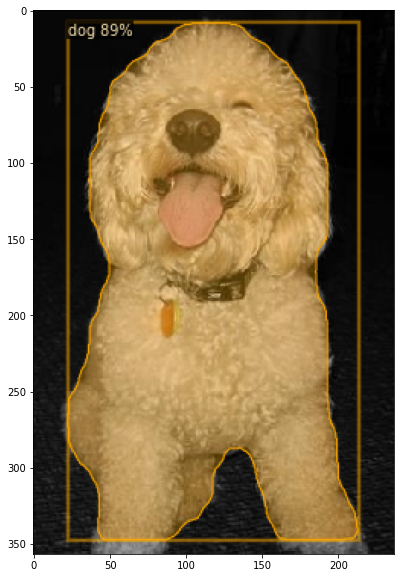

In [16]:
for d in random.sample(test_dataset_dicts, 1):    
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()